# Estructurando un Proyecto de DS (Parte II)

### Abstract

El conjunto de datos que se analiza en este estudio se centra en la reserva de hoteles y la probabilidad de que estas reservas sean canceladas. El dataset contiene información detallada sobre las reservas realizadas en distintos hoteles, incluyendo información sobre el tipo de habitación reservada, la duración de la estancia, la anticipación de la reserva, la fecha de llegada, la cantidad de personas y dias que reservan, entre otros datos.

- ¿Afecta el tipo de mercado el estado final de la reserva?

- ¿Existe relación entre el estado de la reserva y el tiempo de llegada al hotel?

- ¿Hay alguna época en particular en la que se realizan mayor cantidad de cancelaciones?

### Contexto y Problemática Comercial

#### Contexto Comercial y Analítico

El sector turístico es uno de los más importantes y dinámicos de la economía global, y los hoteles son una parte fundamental de esta industria. Los hoteles compiten en un mercado altamente competitivo, por lo que lograr realizar predicciones sobre la cancelación de las reservas realizadas pueden ayudarlos a mantenerse competitivos.

Los diferentes métodos de reserva que existen (y principalmente la reserva online) afectaron fuertemente el comportamiento de los clientes y sus posibilidades de reservas, muchas de las cuales luego son canceladas o no asistidas. Generalmente, el ofrecimiento de cancelaciones gratuitas o a un precio moderado/bajo ayuda a que los huespedes se vean beneficiados, pero conlleva a que los hoteles pierdan rentabilidad ya que para ellos esta metodología de cancelaciones es costosa.

#### Problemática


La cancelación de reservas es un problema común en la industria hotelera y puede afectar significativamente la rentabilidad del hotel. Estas cancelaciones pueden generar costos adicionales para el hotel, como la pérdida de ingresos por habitaciones no vendidas, gastos de cancelación y posibles daños a la reputación del hotel si el cliente queda insatisfecho.

Por lo tanto, es crucial para los hoteles gestionar eficazmente las cancelaciones de reservas para minimizar su impacto en la rentabilidad y la satisfacción del cliente.

Mediante este dataset se busca generar un modelo que ayude a la industria hotelera a gestionar las cancelaciones de las reservas. El dataset tiene mas de 36000 reservas analizadas y diferenciadas en canceladas y no canceladas, ademas de caracteristicas adicionales de las personas, la estadia y las reservas.

### Objetivo

El objetivo principal de este estudio es analizar la probabilidad de que las reservas de hotel sean canceladas y determinar qué factores pueden influir en esta decisión. Para lograr este objetivo, se llevaran a cabo varios análisis estadísticos y van a utilizarse diferentes técnicas de modelado predictivo que nos permitira generar un modelo de clasificación para predecir las posibilidades de que esto ocurra.

### Importación de Librerias

In [144]:
#Numpy
import numpy as np
# Pandas
import pandas as pd
# Matplotlib
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

### Importación de Dataset

Link al dataset: https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [179]:
hotel = pd.read_csv('./ReservaHotel.csv')

In [ ]:
hotel.head()

In [ ]:
hotel.shape

In [ ]:
hotel.info()

Las variables del dataset son:
- Booking_ID: ID de reserva.
- no_of_adults: número de adultos.
- no_of_children: número de niños.
- no_of_weekend_nights: número de noches de fin de semana reservado.
- no_of_week_nights: número de noches de dias de semana reservado.
- type_of_meal_plan: plan de alimentación elegido.
- required_car_parking_space: si requiere estacionamiento o no.
- room_type_reserved: tipo de habitación reservada.
- lead_time: cantidad de dias en que hace la reservación.
- arrival_year: año de llegada al hotel.
- arrival_month: mes de llegada al hotel.
- arrival_date: dia de llegada al hotel.
- market_segment_type: lugar desde el que se realizo la reserva.
- repeated_guest: si la persona que reserva ya habia reservado con anterioridad.
- no_of_previous_cancellations: cantidad de cancelaciones previas.
- no_of_previous_bookings_not_canceled: cantidad de reservas previas no canceladas.
- avg_price_per_room: precio promedio por habitación.
- no_of_special_requests: cantidad de pedidos especiales.
- booking_status: estado final de la reserva.

In [180]:
# unifico las variables arrival para crear una unica variable con la fecha

from datetime import datetime

hotel['arrival'] = hotel['arrival_year'].astype(str) + '-' + hotel['arrival_month'].astype(str) + '-' + hotel['arrival_date'].astype(str)
hotel['arrival'] = pd.to_datetime(hotel['arrival'], format='%Y-%m-%d')

In [181]:
# unifico las variables de adults y children para ver el total de personas.
hotel['total_people'] = hotel['no_of_adults'] + hotel['no_of_children']

# unifico el numero de nights para ver su total
hotel['total_nights'] = hotel['no_of_weekend_nights'] + hotel['no_of_week_nights']

# unifico el numero de reservas anteriores
hotel['previous_booking'] = hotel['no_of_previous_bookings_not_canceled'] + hotel['no_of_previous_cancellations']

In [182]:
# elimino las columnas unificadas
hotel = hotel.drop(columns=['Booking_ID','no_of_adults','no_of_children','no_of_weekend_nights','no_of_week_nights','arrival_year','arrival_month','arrival_date','no_of_previous_cancellations','no_of_previous_bookings_not_canceled'], axis=1)

In [ ]:
hotel.head()

In [ ]:
hotel.shape

### Gráficos descriptivos

In [ ]:
hs = sns.countplot(data=hotel, x= "booking_status", palette='deep')
hs.set_title('Cantidad de reservas según su estado')
labels = ('No cancelada', 'Cancelada')
hs.set_ylabel('Cantidad de resesrvas')
hs.set_xlabel('Estado de reserva')
hs.set_xticklabels(labels)
plt.show()

In [ ]:
hotel['booking_status'].value_counts().mul(100)/len(hotel)

*De acuerdo a lo observado, las reservas NO CANCELADAS alcanzan un total aproximado de 67%, mientras que las reservas CANCELADAS son de alrededor del 33%.*

In [ ]:
hl = sns.boxplot(x='booking_status', y='lead_time', data = hotel)
sns.set(font_scale=1)
hl.set_ylabel('Tiempo de espera')
hl.set_xlabel('Estado de reserva')
hl.set_xticklabels(labels)
plt.title("Lead Time vs. Status")

In [ ]:
hotel['lead_time'].describe()

*En función de lo que visualizamos, podemos determinar que a mayor cantidad de dias de espera para el arribo al hotel, mayor es la tasa de cancelaciones, llegando incluso a visualizar "outliers" con valores mayores a 400 dias. Sin embargo, hay reservas con tiempos de espera menores a esa cantidad que no fueron canceladas*

In [ ]:
hotel_pivot = pd.pivot_table(hotel.reset_index(),columns=['market_segment_type','type_of_meal_plan'],
                             index=['booking_status'],
                             values='index',
                             fill_value=0,
                             aggfunc=len)
hotel_pivot

In [ ]:
hotel_pivot_def = hotel_pivot/len(hotel)*100
hotel_pivot_def

*Analizando las variables de segmento de mercado de acuerdo al plan de comidas y al estado de las reservas, se puede determinar que en el segmento "Complementary", para todos sus planes de comida, no se realizan cancelaciones; si podemos observar que las mayores cancelaciones se producen para las reservas "Online" y el plan de comidas "Meal Plan 1".*

*Tambien se visualiza claramente que, para aquellas reservas que no son canceladas, el plan de comidas "Meal Plan 1" tiene una alta incidencia en dicha decisión( al igual que con las canceladas), por lo que la variable termina teniendo relevancia en nuestro análisis.*

### Cuarta Entrega

Revisión de tipos de variables

In [ ]:
hotel.dtypes

Armare 2 dataframes de acuerdo al tipo de variable a analizar, uno con las variables cualitativas y otra con las variables cuantitativas.

#### Variables Cuantitativas

In [ ]:
hotel_cuant = hotel.select_dtypes(include = np.number)
hotel_cuant.info()

In [ ]:
hotel_cuant.describe()

In [ ]:
for i in hotel_cuant:
    plt.figure(figsize=(18, 6))
    sns.histplot(x =i, data = hotel_cuant)
    sns.set(font_scale = 1)
    plt.show() 

#### Variables Cualitativas

In [ ]:
hotel_cuali = hotel.select_dtypes(include= object)
hotel_cuali.info()

In [ ]:
for col in hotel_cuali.columns:
    print(hotel_cuali[col].unique())
    print(hotel_cuali[col].nunique())

In [ ]:
for i in hotel_cuali:
    plt.figure(figsize=(18, 6))
    sns.countplot(x =i, data = hotel_cuali, palette = 'bright')
    sns.set(font_scale = 1)
    plt.show()  


In [ ]:
ht_meal = pd.crosstab(hotel_cuali.booking_status, hotel_cuali.type_of_meal_plan, normalize='columns')
ht_meal

In [ ]:
ht_meal.plot(kind='bar') 
plt.grid(color = 'w')
plt.xlabel ('Estado de la reserva')
plt.ylabel ('Frecuencia relativa')
plt.show()

In [ ]:
ht_room = pd.crosstab(hotel_cuali.booking_status, hotel_cuali.room_type_reserved, normalize='columns')
ht_room

In [ ]:
ht_room.plot(kind='bar') 
plt.grid(color = 'w')
plt.xlabel ('Estado de la reserva')
plt.ylabel ('Frecuencia relativa')
plt.show()

In [ ]:
ht_segment = pd.crosstab(hotel_cuali.booking_status, hotel_cuali.market_segment_type, normalize='columns')
ht_segment

In [ ]:
ht_segment.plot(kind='bar') 
plt.grid(color = 'w')
plt.xlabel ('Estado de la reserva')
plt.ylabel ('Frecuencia relativa')
plt.show()

In [ ]:
htcancel = hotel["booking_status"]
htcancel

In [ ]:
hotel_cuant["iscancel"] = htcancel
hotel_cuant.info() 

In [ ]:
sns.pairplot(hotel_cuant, hue='iscancel')

### Exploratory Data Analysis

- Las personas que realizaron reservas previas en el mismo hotel no registran cancelaciones.
- Se observan 2 nubes bien diferenciadas para el precio promedio de habitación (avg_price_per_room) y para el tiempo de espera (lead_time).
- Aproximadamente el 50% de las reservas que comprenden el plan 2 de comidas (type_of_meal_plan) son canceladas.
- Las reservas realizadas se mantienen para 9 de cada 10 en la categoria "Corporate" (market_segment_type)
- Se observa que la variable target sería "booking_status" para ver la cancelación de las reservas.


### Correlación de las variables

In [ ]:
correlation = hotel.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap = 'YlOrBr')

No se visualiza una correlación muy fuerte entre las variables.

### Transformación de variables categóricas a numéricas

In [167]:
hotel.head()

,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,avg_price_per_room,no_of_special_requests,booking_status,arrival,total_people,total_nights,previous_booking
0,Meal Plan 1,0,Room_Type 1,224,Offline,0,65.00,0,Not_Canceled,2017-10-02,2,3,0
1,Not Selected,0,Room_Type 1,5,Online,0,106.68,1,Not_Canceled,2018-11-06,2,5,0
2,Meal Plan 1,0,Room_Type 1,1,Online,0,60.00,0,Canceled,2018-02-28,1,3,0
3,Meal Plan 1,0,Room_Type 1,211,Online,0,100.00,0,Canceled,2018-05-20,2,2,0
4,Not Selected,0,Room_Type 1,48,Online,0,94.50,0,Canceled,2018-04-11,2,2,0


In [183]:
hotel.type_of_meal_plan.unique()

array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2', 'Meal Plan 3'],
      dtype=object)

In [184]:
map_meal = {'Not Selected': 0, 'Meal Plan 1': 1, 'Meal Plan 2': 2, 'Meal Plan 3': 3}
hotel["type_of_meal_plan"] = hotel["type_of_meal_plan"].replace(map_meal)
hotel["type_of_meal_plan"]  

0        1
1        0
2        1
3        1
4        0
        ..
36270    1
36271    1
36272    1
36273    0
36274    1
Name: type_of_meal_plan, Length: 36275, dtype: int64

In [185]:
hotel.room_type_reserved.unique()

array(['Room_Type 1', 'Room_Type 4', 'Room_Type 2', 'Room_Type 6',
       'Room_Type 5', 'Room_Type 7', 'Room_Type 3'], dtype=object)

In [186]:
map_room = {'Room_Type 1': 1, 'Room_Type 4': 4, 'Room_Type 2': 2, 'Room_Type 6': 6,
       'Room_Type 5': 5, 'Room_Type 7': 7, 'Room_Type 3': 3}
hotel["room_type_reserved"] = hotel["room_type_reserved"].replace(map_room)
hotel["room_type_reserved"]

0        1
1        1
2        1
3        1
4        1
        ..
36270    4
36271    1
36272    1
36273    1
36274    1
Name: room_type_reserved, Length: 36275, dtype: int64

In [187]:
hotel.booking_status.unique()

array(['Not_Canceled', 'Canceled'], dtype=object)

In [188]:
map_booking = {'Not_Canceled': 0, 'Canceled': 1}
hotel["booking_status"] = hotel["booking_status"].replace(map_booking)
hotel["booking_status"]

0        0
1        0
2        1
3        1
4        1
        ..
36270    0
36271    1
36272    0
36273    1
36274    0
Name: booking_status, Length: 36275, dtype: int64

In [189]:
hotel_segment = pd.get_dummies(hotel["market_segment_type"], prefix="market")
hotel_segment.head()

,market_Aviation,market_Complementary,market_Corporate,market_Offline,market_Online
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [190]:
hotel = hotel.drop(["market_segment_type"], axis = 1)
hotel.head()

,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,repeated_guest,avg_price_per_room,no_of_special_requests,booking_status,arrival,total_people,total_nights,previous_booking
0,1,0,1,224,0,65.00,0,0,2017-10-02,2,3,0
1,0,0,1,5,0,106.68,1,0,2018-11-06,2,5,0
2,1,0,1,1,0,60.00,0,1,2018-02-28,1,3,0
3,1,0,1,211,0,100.00,0,1,2018-05-20,2,2,0
4,0,0,1,48,0,94.50,0,1,2018-04-11,2,2,0


In [191]:
hotel_concat = pd.concat([hotel, hotel_segment], axis = 1)
hotel = hotel_concat
hotel.head()

,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,repeated_guest,avg_price_per_room,no_of_special_requests,booking_status,arrival,total_people,total_nights,previous_booking,market_Aviation,market_Complementary,market_Corporate,market_Offline,market_Online
0,1,0,1,224,0,65.00,0,0,2017-10-02,2,3,0,0,0,0,1,0
1,0,0,1,5,0,106.68,1,0,2018-11-06,2,5,0,0,0,0,0,1
2,1,0,1,1,0,60.00,0,1,2018-02-28,1,3,0,0,0,0,0,1
3,1,0,1,211,0,100.00,0,1,2018-05-20,2,2,0,0,0,0,0,1
4,0,0,1,48,0,94.50,0,1,2018-04-11,2,2,0,0,0,0,0,1


In [192]:
hotel.head()

,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,repeated_guest,avg_price_per_room,no_of_special_requests,booking_status,arrival,total_people,total_nights,previous_booking,market_Aviation,market_Complementary,market_Corporate,market_Offline,market_Online
0,1,0,1,224,0,65.00,0,0,2017-10-02,2,3,0,0,0,0,1,0
1,0,0,1,5,0,106.68,1,0,2018-11-06,2,5,0,0,0,0,0,1
2,1,0,1,1,0,60.00,0,1,2018-02-28,1,3,0,0,0,0,0,1
3,1,0,1,211,0,100.00,0,1,2018-05-20,2,2,0,0,0,0,0,1
4,0,0,1,48,0,94.50,0,1,2018-04-11,2,2,0,0,0,0,0,1


#### Separo las variables de la variable target

In [235]:
hotel_train = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved',
       'lead_time', 'repeated_guest', 'avg_price_per_room',
       'no_of_special_requests', 'total_people',
       'total_nights', 'market_Aviation',
       'market_Complementary', 'market_Corporate', 'market_Offline',
       'market_Online']
X = hotel[hotel_train]
y = hotel['booking_status']


In [236]:
X

,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,repeated_guest,avg_price_per_room,no_of_special_requests,total_people,total_nights,market_Aviation,market_Complementary,market_Corporate,market_Offline,market_Online
0,1,0,1,224,0,65.00,0,2,3,0,0,0,1,0
1,0,0,1,5,0,106.68,1,2,5,0,0,0,0,1
2,1,0,1,1,0,60.00,0,1,3,0,0,0,0,1
3,1,0,1,211,0,100.00,0,2,2,0,0,0,0,1
4,0,0,1,48,0,94.50,0,2,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,1,0,4,85,0,167.80,1,3,8,0,0,0,0,1
36271,1,0,1,228,0,90.95,2,2,4,0,0,0,0,1
36272,1,0,1,148,0,98.39,2,2,8,0,0,0,0,1
36273,0,0,1,63,0,94.50,0,2,3,0,0,0,0,1


In [237]:
y

0        0
1        0
2        1
3        1
4        1
        ..
36270    0
36271    1
36272    0
36273    1
36274    0
Name: booking_status, Length: 36275, dtype: int64

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Feature Selection

In [251]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report, accuracy_score, confusion_matrix
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#### mlxtend y crossvalidation


In [239]:
sfs = SFS(LogisticRegression(),
          k_features=4,
          cv = 3)

In [240]:
sfs.fit(X_train,y_train)

SequentialFeatureSelector(cv=3, estimator=LogisticRegression(),
                          k_features=(4, 4), scoring='accuracy')

In [241]:
sfs.k_feature_names_

('lead_time', 'avg_price_per_room', 'no_of_special_requests', 'market_Online')

In [242]:
sfs.k_feature_idx_

(3, 5, 6, 13)

Los índices obtenidos corresponden a las columnas:

3 - lead_time
5 - avg_price_per_room
6 - no_of_special_requests
13 - market_online

#### Modelos

In [245]:
modelo1 = LogisticRegression(max_iter=5000)

In [246]:
modelo1.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [247]:
ypred = modelo1.predict(X_test)

In [250]:
accuracy_score(ypred, y_test)

0.7989855551880031

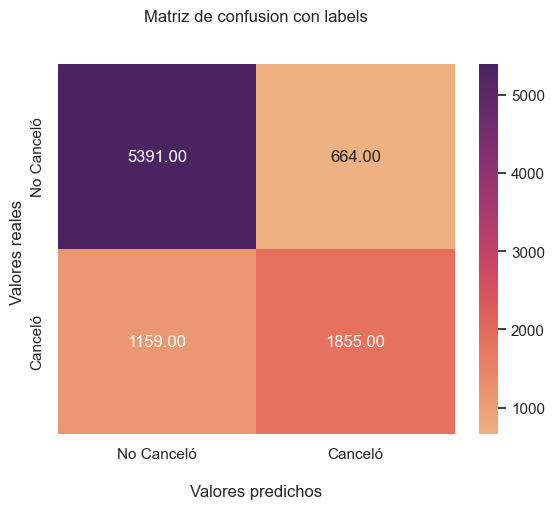

In [254]:
cf_matrix = confusion_matrix(y_test, ypred,)
ax = sns.heatmap(cf_matrix, annot=True, cmap='flare',fmt=".2f")
ax.set_title('Matriz de confusion con labels\n\n');
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores reales ');
ax.xaxis.set_ticklabels(['No Canceló','Canceló'])
ax.yaxis.set_ticklabels(['No Canceló','Canceló'])
plt.show()